In [201]:
# Parameters
artificial_humans = "../data/dev/data/model.pt"
output_file = "../data/dev/data/manager_run.pt"
model_args = {"n_layers": 2, "hidden_size": 5}
opt_args = {'lr': 0.01}
gamma = 0.50
eps = 0.1
target_update_freq = 10
n_episodes = 1000
sample_args = {
    'batch_size': 10,
    'horizon': 100
}

In [202]:
%load_ext autoreload
%autoreload 2

import torch as th
from aimanager.model.memory import Memory
from aimanager.model.environment import ArtificialHumanEnv
from aimanager.model.artificial_humans import ArtificialHuman
from aimanager.model.neural.mlp import MultiLayer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
import torch as th
import numpy as np

def shift_obs(tensor_dict):
    """
    Creates previous and current observations.

    Args:
        tensor_dict: each tensor need to have the episode_step dimension at second position
    """
    previous = {k: t[:, :-1] for k, t in tensor_dict.items()}
    current = {k: t[:, 1:] for k, t in tensor_dict.items()}
    return previous, current


class ArtificalManager():
    def __init__(
            self, *, n_contributions, n_punishments, model_args, opt_args, gamma, target_update_freq, device):
        self.device = device
        input_size = n_contributions
        self.policy_model = MultiLayer(output_size=n_punishments, input_size=input_size, **model_args).to(device)
        self.target_model = MultiLayer(output_size=n_punishments, input_size=input_size, **model_args).to(device)

        self.target_model.eval()
        self.optimizer = th.optim.RMSprop(self.policy_model.parameters(), **opt_args)
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.n_contributions = n_contributions
        self.n_punishments = n_punishments

    def init_episode(self, episode):
        if (episode % self.target_update_freq == 0):
            # copy policy net to target net
            self.target_model.load_state_dict(self.policy_model.state_dict())

        # TODO: add for rnn
        # self.policy_model.reset()
        # self.target_model.reset()

    def encode_obs(self, contributions, **_):
        return {
            'manager_observations': th.nn.functional.one_hot(contributions, num_classes=self.n_contributions).float()
        }

    def get_q(self, manager_observations, **_):
        with th.no_grad():
            return self.policy_model(manager_observations)

    def act(self, **state):
        obs = self.encode_obs(**state)
        q = self.get_q(**obs)
        return q.argmax(dim=-1)

    def eps_greedy(self, q_values, eps):
        """
        Args:
            q_values: Tensor of type `th.float` and arbitrary shape, last dimension reflect the actions.
            eps: fraction of actions sampled at random
        Returns:
            actions: Tensor of type `th.long` and the same dimensions then q_values, besides of the last.
        """
        n_actions = q_values.shape[-1]
        actions_shape = q_values.shape[:-1]

        greedy_actions = q_values.argmax(-1)
        random_actions = th.randint(0, n_actions, size=actions_shape, device=self.device)

        # random number which determine whether to take the random action
        random_numbers = th.rand(size=actions_shape, device=device)
        select_random = (random_numbers < eps).long()
        picked_actions = select_random * random_actions + (1 - select_random) * greedy_actions

        return picked_actions


    def update(self, actions, rewards, manager_observations, **_):
        previous_obs = manager_observations[:, :-1]
        current_obs = manager_observations[:, 1:]
        actions = actions[:, 1:]
        rewards = rewards[:, 1:]
        # current = {k: t[:, 1:] for k, t in tensor_dict.items()}


        # t[:, :-1]t[:, :-1]
        # previous_obs, current_obs = shift_obs(obs)

        # self.policy_model.reset()
        # self.target_model.reset()

        policy_state_action_values = self.policy_model(
            previous_obs).gather(-1, actions.unsqueeze(-1))

        next_state_values = th.zeros_like(rewards, device=self.device)
        next_state_values = self.target_model(current_obs).max(-1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + rewards[:,:,np.newaxis] * 0.25

        # Compute Huber loss
        loss = th.nn.functional.smooth_l1_loss(policy_state_action_values,
                                               expected_state_action_values.unsqueeze(-1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [204]:
# from aimanager.model.neural.random import RandomArtificialHumans

device = th.device('cpu')
rec_device = th.device('cpu')
# rah = RandomArtificialHumans(device=device, max_contribution=20)
artifical_humans = ArtificialHuman.load(artificial_humans)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=16, device=device)

In [205]:
# state = env.init_episode()
# print(state)
# done = False
# while not done:
#     punishments = th.randint(0, 31, (4,), device=device)
#     state, reward, done = env.step(punishments)
#     print(state, reward, done)


In [206]:
from itertools import count

manager = ArtificalManager(
    n_contributions=21, n_punishments=31, model_args=model_args, opt_args=opt_args, gamma=gamma, 
    target_update_freq=target_update_freq, device=device)

memory = Memory(n_episodes=n_episodes, n_episode_steps=16, output_file=output_file, device=device)


for episode in range(n_episodes):
    if episode % 10 == 0:
        print(f'Start episode {episode}.')
    state = env.init_episode()

    # initialize episode for all controller
    manager.init_episode(episode)
    memory.next_episode(episode)

    for step in count():
        # Get observations
        state_enc = manager.encode_obs(**state)

        # Get q values from controller
        q_values = manager.get_q(**state_enc)

        # Sample a action
        selected_actions = manager.eps_greedy(q_values=q_values, eps=eps)
        # pass actions to environment and advance by one step
        state, rewards, done = env.step(selected_actions)
        memory.add(episode_step=step, actions=selected_actions, rewards=rewards, **state_enc)

        if done:
            # allow all controller to update themself
            sample = memory.sample(**sample_args)
            if sample is not None:
                manager.update(**sample)
            break

Start episode 0.
Start episode 10.
Start episode 20.
Start episode 30.
Start episode 40.
Start episode 50.
Start episode 60.
Start episode 70.
Start episode 80.
Start episode 90.
Start episode 100.
Start episode 110.
Start episode 120.
Start episode 130.
Start episode 140.
Start episode 150.
Start episode 160.
Start episode 170.
Start episode 180.
Start episode 190.
Start episode 200.
Start episode 210.
Start episode 220.
Start episode 230.
Start episode 240.
Start episode 250.
Start episode 260.
Start episode 270.
Start episode 280.
Start episode 290.
Start episode 300.
Start episode 310.
Start episode 320.
Start episode 330.
Start episode 340.
Start episode 350.
Start episode 360.
Start episode 370.
Start episode 380.
Start episode 390.
Start episode 400.
Start episode 410.
Start episode 420.
Start episode 430.
Start episode 440.
Start episode 450.
Start episode 460.
Start episode 470.
Start episode 480.
Start episode 490.
Start episode 500.
Start episode 510.
Start episode 520.
Star

In [207]:
data = {
    'contributions': th.arange(0,21)
}

# obs = manager.

data['punishments'] = manager.act(**data)


<AxesSubplot:xlabel='contributions', ylabel='punishments'>

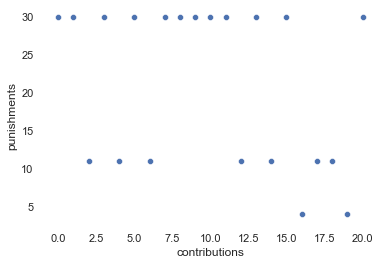

In [208]:
import seaborn as sns
import pandas as pd

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

df = pd.DataFrame(data)
sns.scatterplot(data=data, x='contributions', y='punishments')